# Libs

In [28]:
import math
import warnings

import numpy as np
import arviz as az
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.special as sc
import theano.tensor as tt
import matplotlib.pyplot as plt
from scipy import stats
#from theano import shared, function
#from pymc3.distributions.dist_math import betaln, bound

from custom import pert

warnings.simplefilter(action="ignore", category=FutureWarning)

In [29]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC v3.11.4
Running on ArviZ v0.11.2


# Main

## Passenger Car

In [30]:
car_milage = 2400000 # avg passenger car milage (km)
car_weight = 1000 # avg passenger car weight in (kg)

car_maint = 1080 # GHG per car caused by maintenance (kg)
car_maint_ghg = car_maint / car_milage # GHG per every km caused by maintenance (kg/km)

car_prod = 7 # GHG per kg of car weight caused by production (kg/kg)
car_prod_ghg = car_prod * car_weight / car_milage # GHG per every km caused by production (kg/km)

car_prod_maint_ghg = car_maint_ghg + car_prod_ghg


## Pure Players

### Model

In [45]:
with pm.Model():    
    pp_product_volume = pm.Lognormal(name='Product Weight', mu=-1.38, sigma=1.14) # volume of product in liters (l)
    pp_box_saturation = pert(name='Box Saturation', a=.1, b=.5, c=.9, transform=None) # share of box volume consumed by product (l/l)
    pp_waste_ghg = pm.Bernoulli(name='Waste GHG', p=.21) * 0.15 # GHG of cardboard disposal (either 0 or 0.15)
    
    pp_cardboard_weight = 12.5 # grams of cardboard per every liter of box volume (g/l)
    pp_cardboard_used = pm.Deterministic(name='PP Cardboard Used', var=pp_cardboard_weight * pp_product_volume / pp_box_saturation) # distribution of weights of cardbord per single package (g)

    pp_cardboard_ghg = .001 # kg GHG per g of cardboard (kg/g)
    pp_cardboard_total_ghg = pm.Deterministic(name='PP Cardboard GHG', var=pp_cardboard_used * (pp_cardboard_ghg + pp_waste_ghg))

    pp_paper_weight = .033 # grams of paper per every liter of void volume (g/l)
    pp_paper_used = pm.Deterministic(name='PP Paper Used', var=pp_paper_weight * pp_product_volume * (1 - pp_box_saturation))
    
    pp_paper_ghg = .0012 # kg GHG per g of paper (kg/g)
    pp_paper_total_ghg = pm.Deterministic(name='PP Paper GHG', var=pp_paper_used * (pp_paper_ghg + pp_waste_ghg))
    
    pp_package_total_ghg = pm.Deterministic(name='PP Package GHG', var=pp_cardboard_total_ghg+pp_paper_total_ghg)
    
    
    pp_stem_mileage = pm.Lognormal(name='PP Stem Mileage', mu=2.88, sigma=.76) * 2 # stem mileage (km)
    pp_drop_mileage = pert(name='PP Drop Mileage', a=3.6, b=40, c=96, transform=None) # drop mileage (km)
    pp_lm_distance = pm.Deterministic(name='PP LM Distance', var=pp_stem_mileage + pp_drop_mileage) # total last-mile distance (km)
    pp_deliveries = pert(name='PP Deliveries per Tour', a=32, b=100, c=168, transform=None) # number of completed deliveries per tour
    pp_drop_distance = pm.Deterministic(name='PP Distance per Drop', var=pp_lm_distance / pp_deliveries) # distance travelled per item drop (km)
    
    pp_cargobike_bike_ghg = .05 # GHG emission intensity of cargobike itself (kg/km)
    pp_cargobike_battery_ghg = .01 # GHG emission intensity of cargobike battery (kg/km)
    pp_cargobike_electricity_CN_ghg = .02 * 1.19 # GHG emission intensity of electricity comnsumption in Chine (kg/km)
    pp_cargobike_electricity_NL_ghg = .02 * .62 # Netherlands
    pp_cargobike_electricity_UK_ghg = .02 * .83 # UK
    pp_cargobike_electricity_US_ghg = .02 * .7 # US
    
    pp_cargobike_total_ghg = pp_cargobike_bike_ghg + pp_cargobike_battery_ghg + pp_cargobike_electricity_CN_ghg # average cargobike GHG per km (kg/km)
    pp_van_ghg = pm.Lognormal(name='PP Van GHG', mu=-1.36, sigma=.23) # delivery van GHG per km (kg/km)
    pp_car_ghg = .13 + car_prod_maint_ghg # average car GHG per km (kg/km)
    
    pp_drop_ghg = pm.Deterministic(name='PP Van GHG per Drop', var=pp_van_ghg * pp_drop_distance) # GHG per item drop using a van (kg)
    pp_drop_cargobike_ghg = pm.Deterministic(name='PP Cargobike GHG per Drop', var=pp_van_ghg * pp_stem_mileage / pp_deliveries + pp_cargobike_total_ghg * pp_drop_mileage / pp_deliveries) # GHG per item drop using a van and a cargobike (kg)
    
    pp_failed = pm.Bernoulli(name='PP Failed Delivery', p=.14)
    pp_redelivered = pm.Bernoulli(name='PP Redelivery of Failed', p=.5)
    pp_distance_cdp = pert(name='PP Distance to CDP', a=2, b=4, c=10, transform=None) # ditance to collection & delivery point (km)

    pp_total_drop_ghg = pm.Deterministic(name='PP Total GHG per Drop (van)', var=pp_drop_ghg + pp_failed * pp_redelivered * pp_drop_ghg + pp_failed * tt.switch(tt.eq(pp_redelivered, 1), 0, 1) * tt.switch(tt.gt(pp_distance_cdp, 4), 1, 0) * pp_distance_cdp * pp_car_ghg)
    pp_total_drop_cargobike_ghg = pm.Deterministic(name='PP Total GHG per Drop (cargobike)', var=pp_drop_cargobike_ghg + pp_failed * pp_redelivered * pp_drop_cargobike_ghg + pp_failed * tt.switch(tt.eq(pp_redelivered, 1), 0, 1) * tt.switch(tt.gt(pp_distance_cdp, 4), 1, 0) * pp_distance_cdp * pp_car_ghg)
    
    
    pp_basket = pert(name='PP Basket Size', a=1, b=2, c=5, transform=None) # basket size distribution for pure players

    pp_total_item_ghg = pm.Deterministic(name='PP Total GHG per Item (van)', var=(pp_package_total_ghg + pp_total_drop_ghg) / pp_basket)
    pp_total_cargobike_item_ghg = pm.Deterministic(name='PP Total GHG per Item (cargobike)', var=(pp_package_total_ghg + pp_total_drop_cargobike_ghg) / pp_basket)
    
    data = pm.sample(100000, tune=10000)
                            

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [PP Basket Size, PP Distance to CDP, PP Van GHG, PP Deliveries per Tour, PP Drop Mileage, PP Stem Mileage, Box Saturation, Product Weight]
>BinaryGibbsMetropolis: [Waste GHG, PP Failed Delivery, PP Redelivery of Failed]


Sampling 4 chains for 10_000 tune and 100_000 draw iterations (40_000 + 400_000 draws total) took 179 seconds.
There were 93105 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91208 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92009 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94724 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


### Sampling

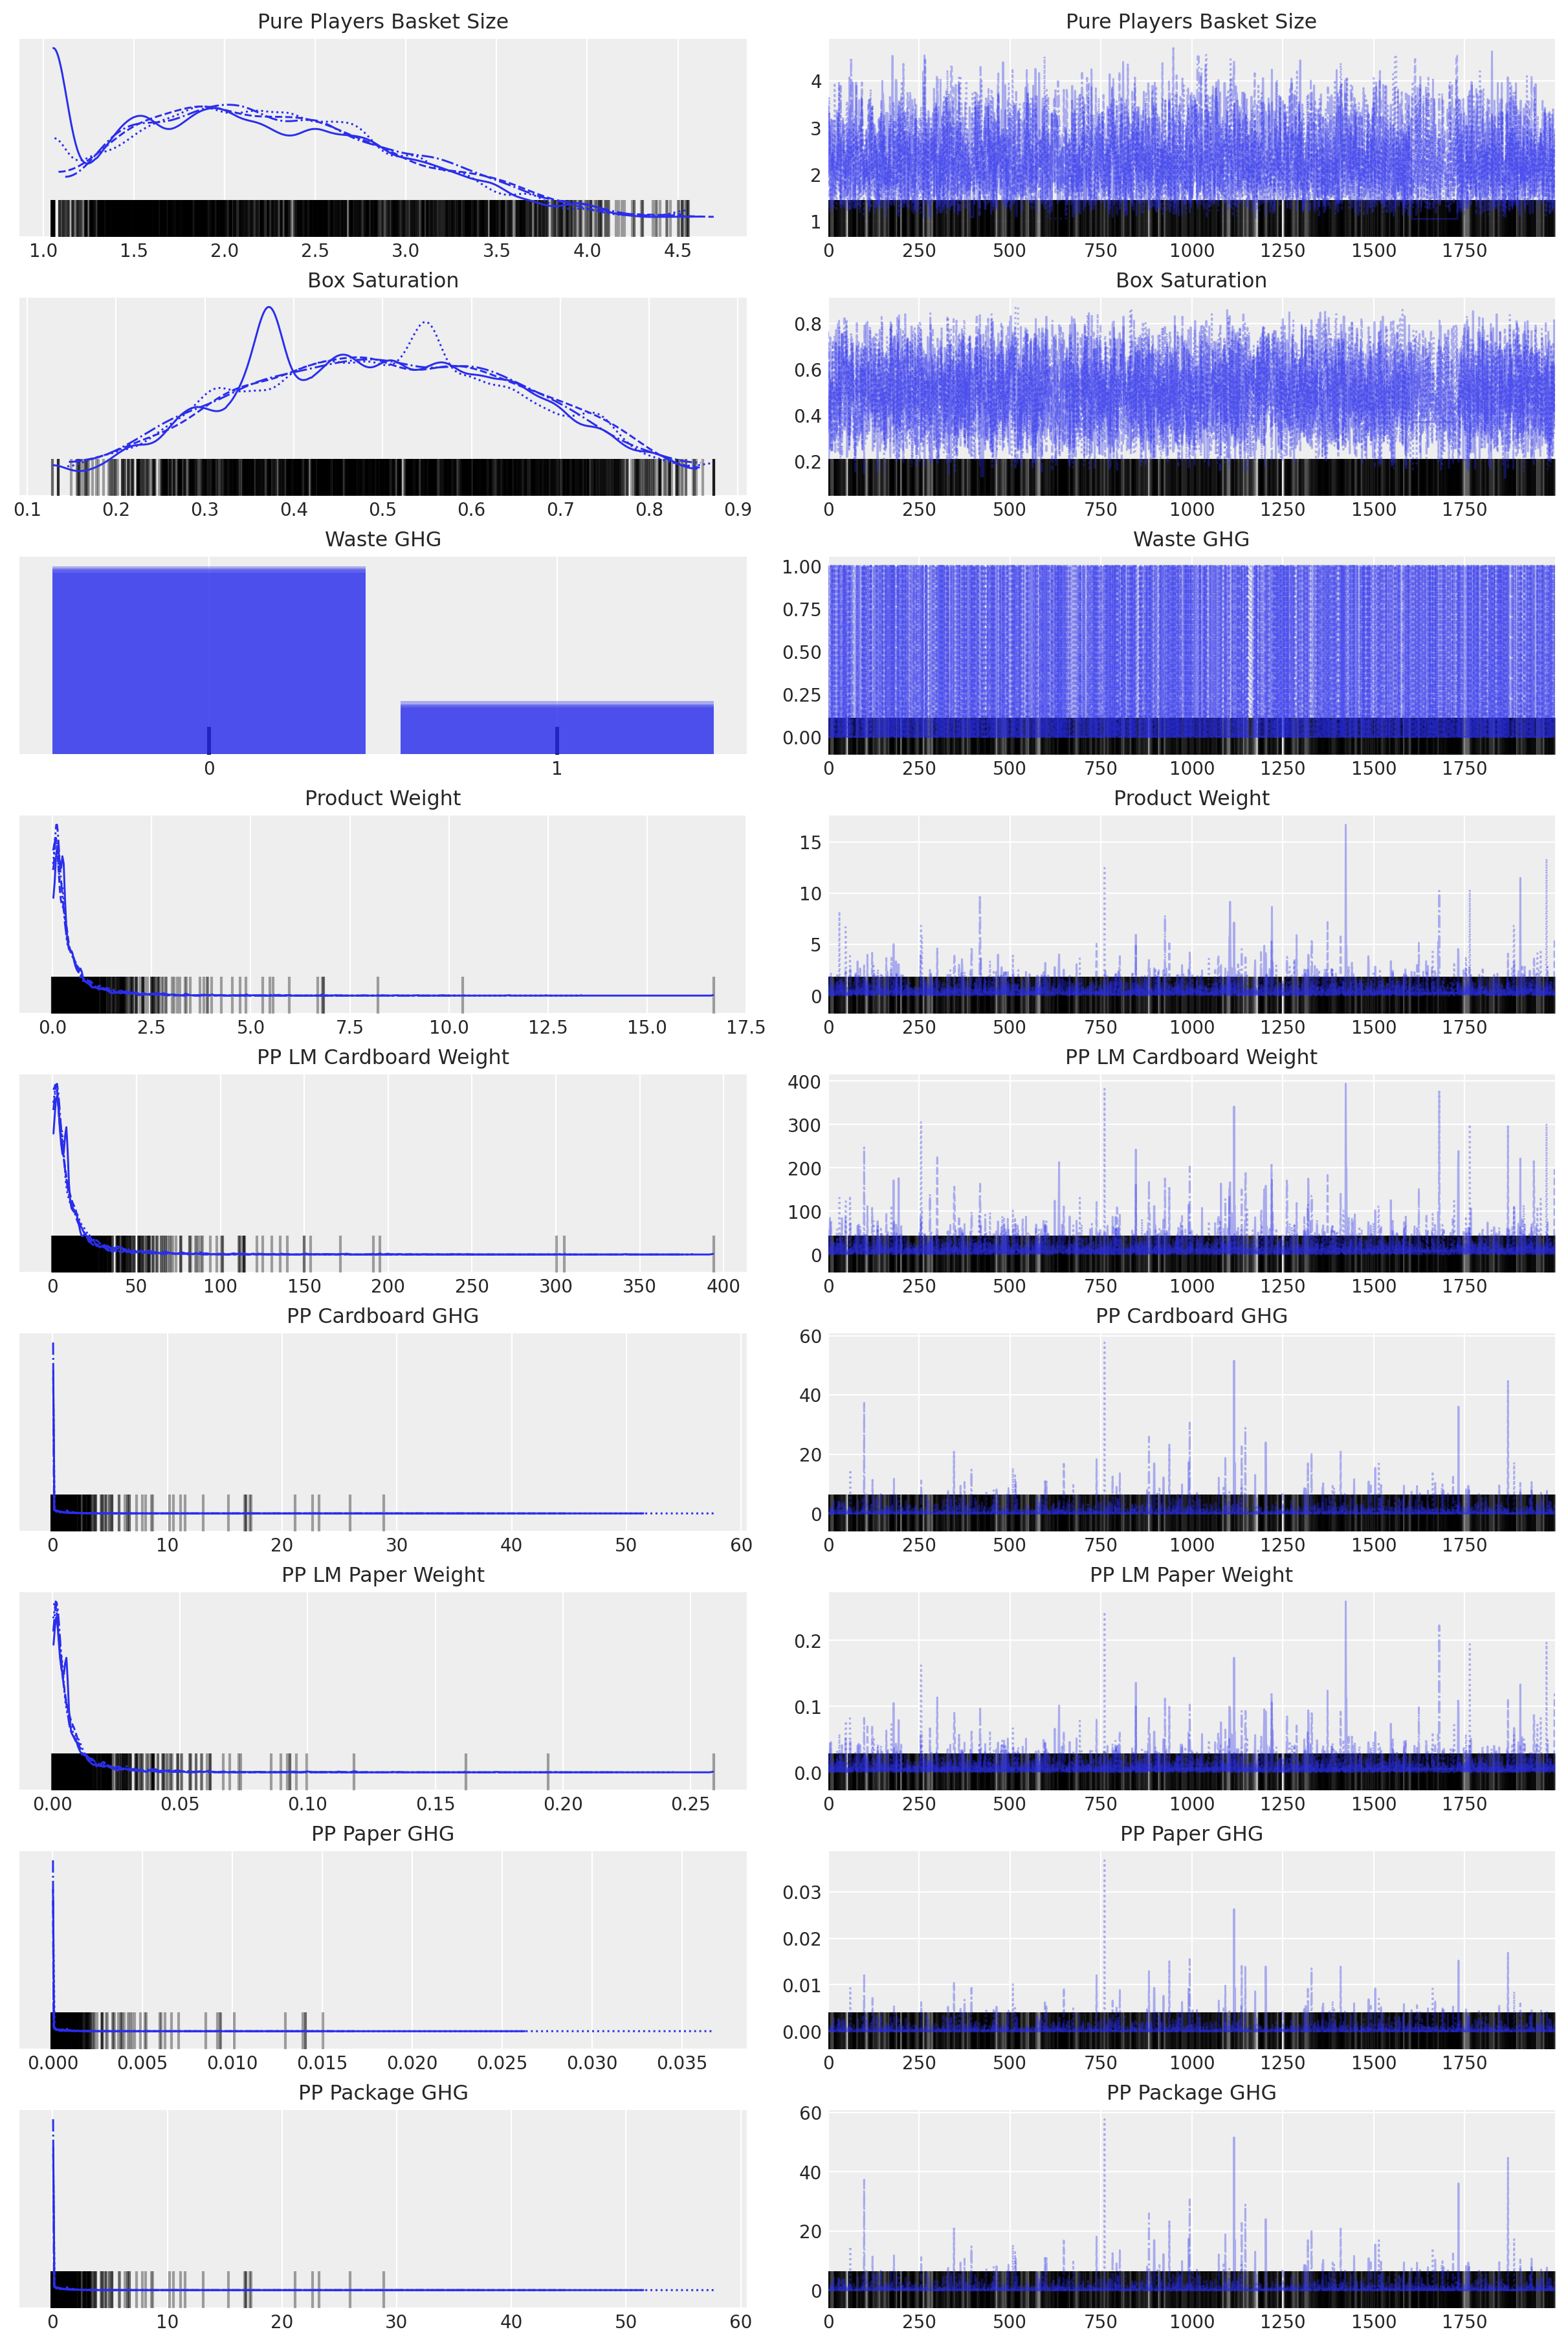

In [4]:
az.plot_trace(data);

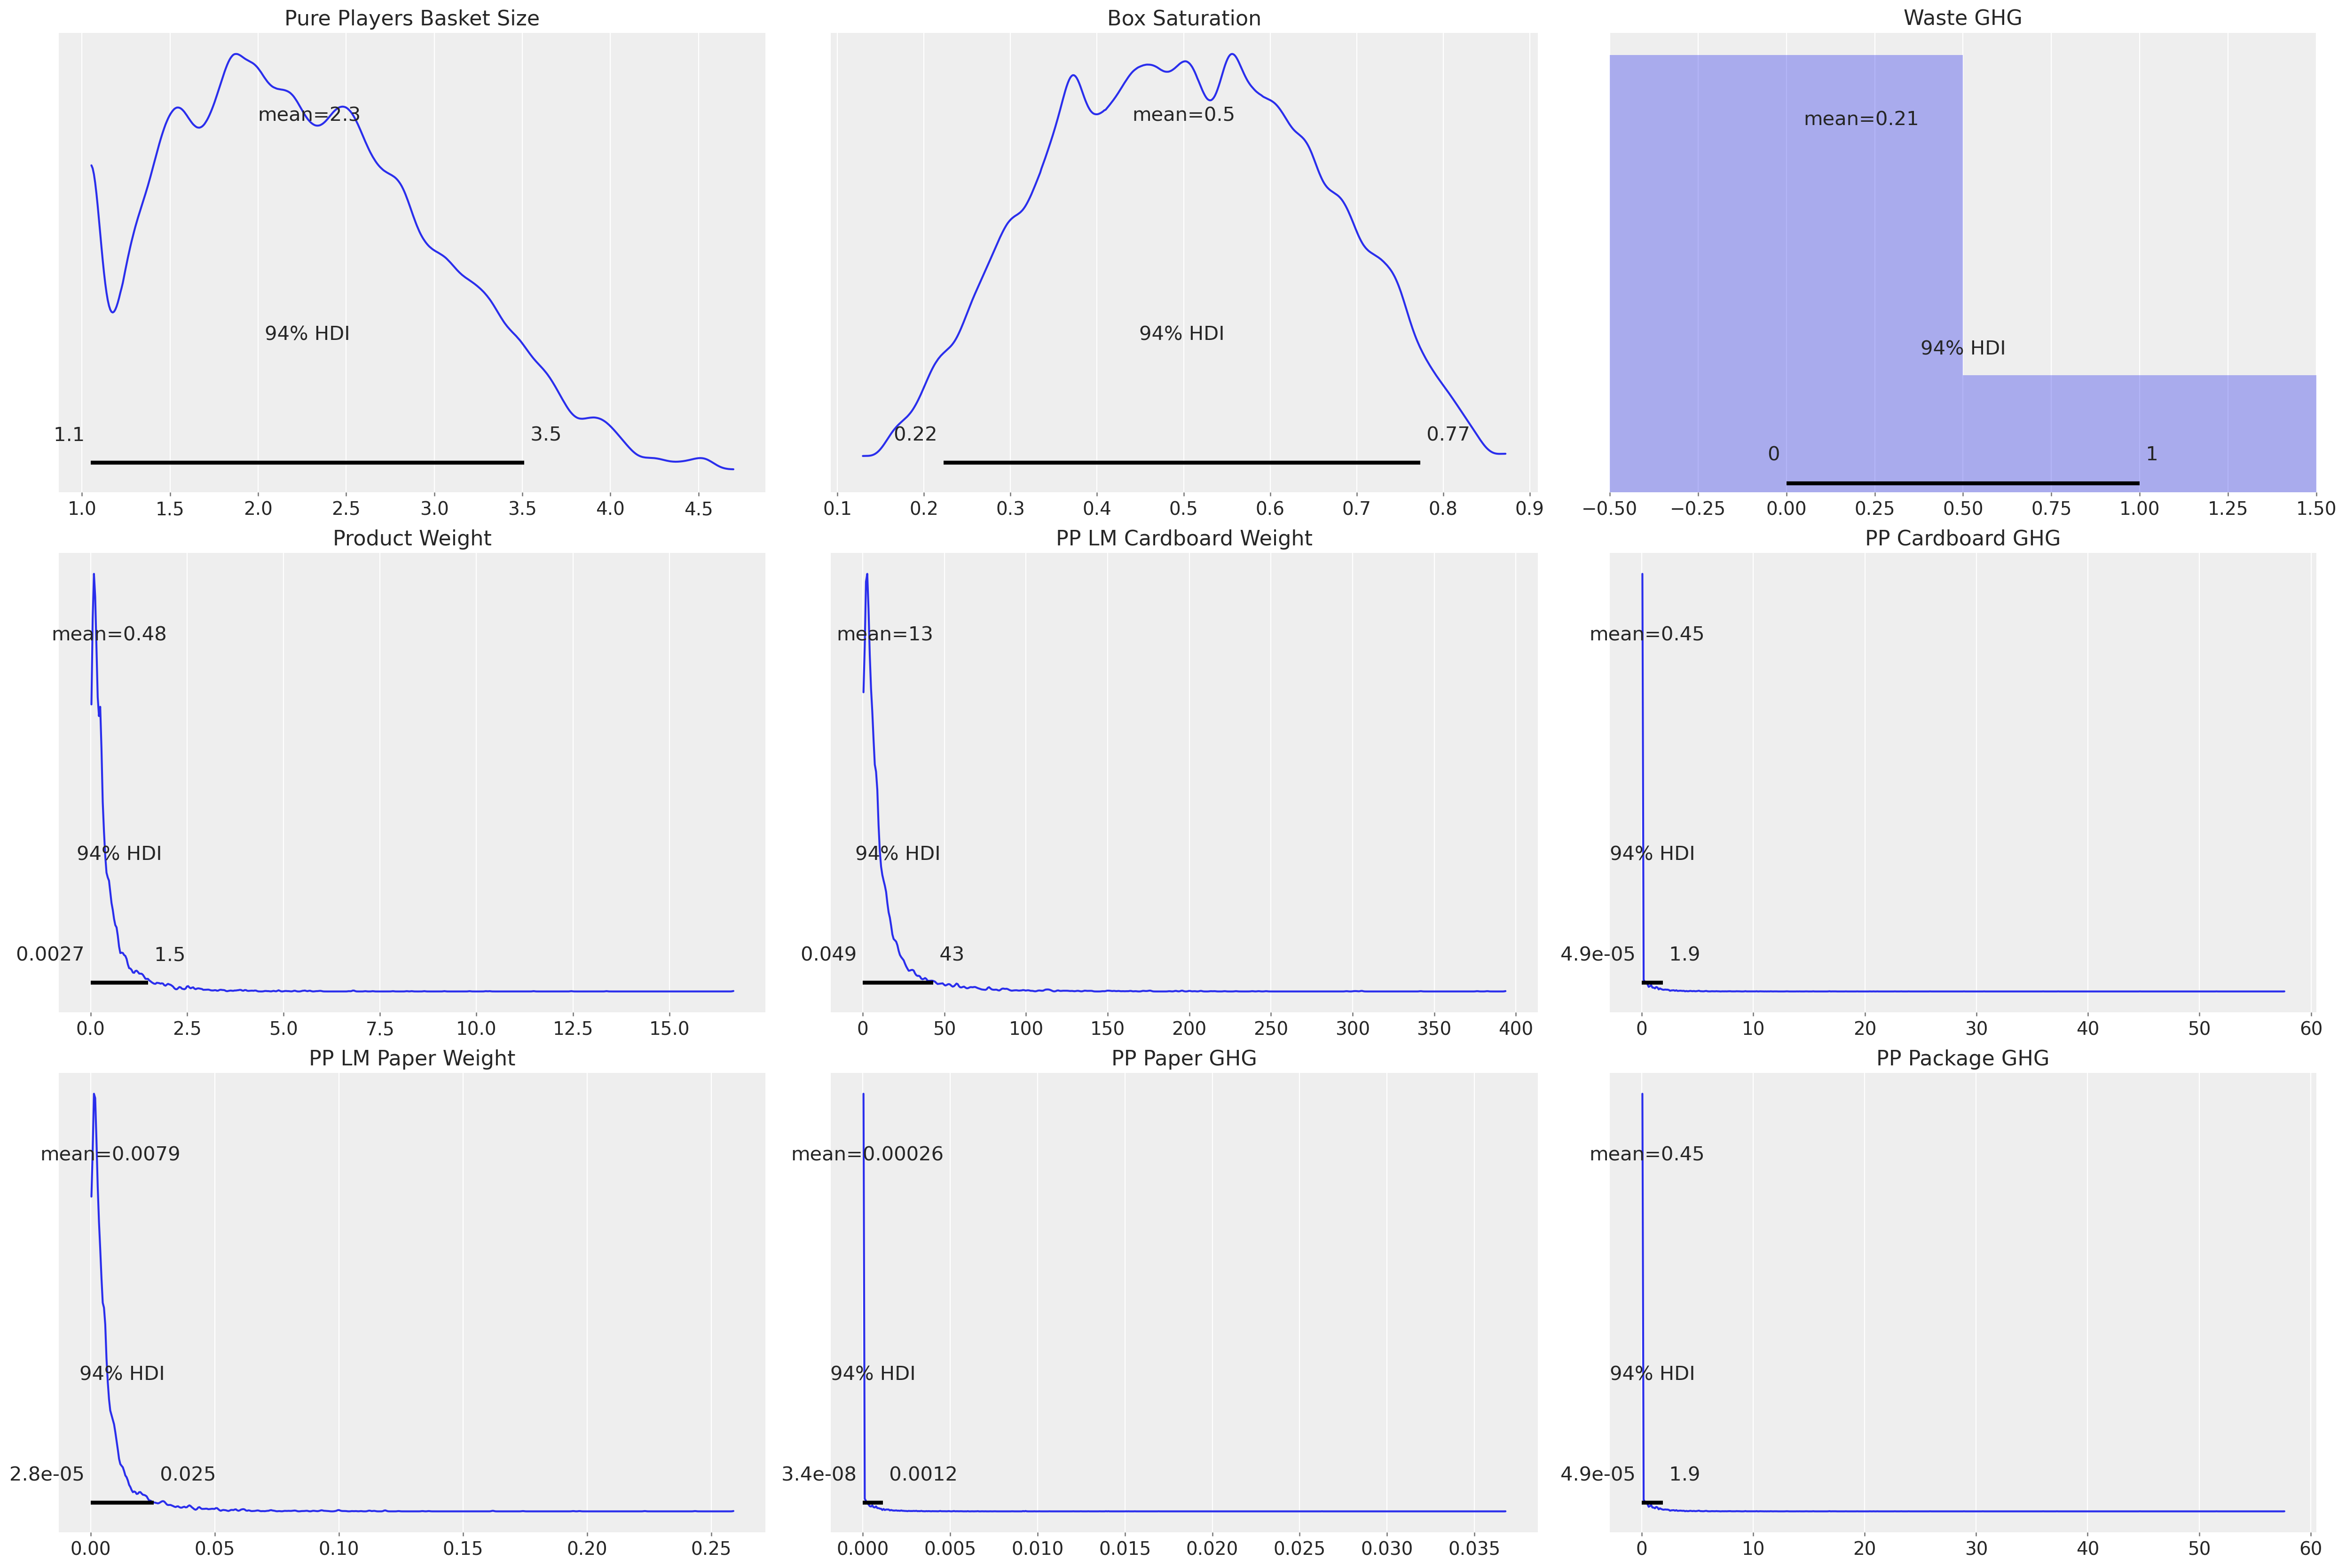

In [5]:
az.plot_posterior(data);

<AxesSubplot:title={'center':'x'}>

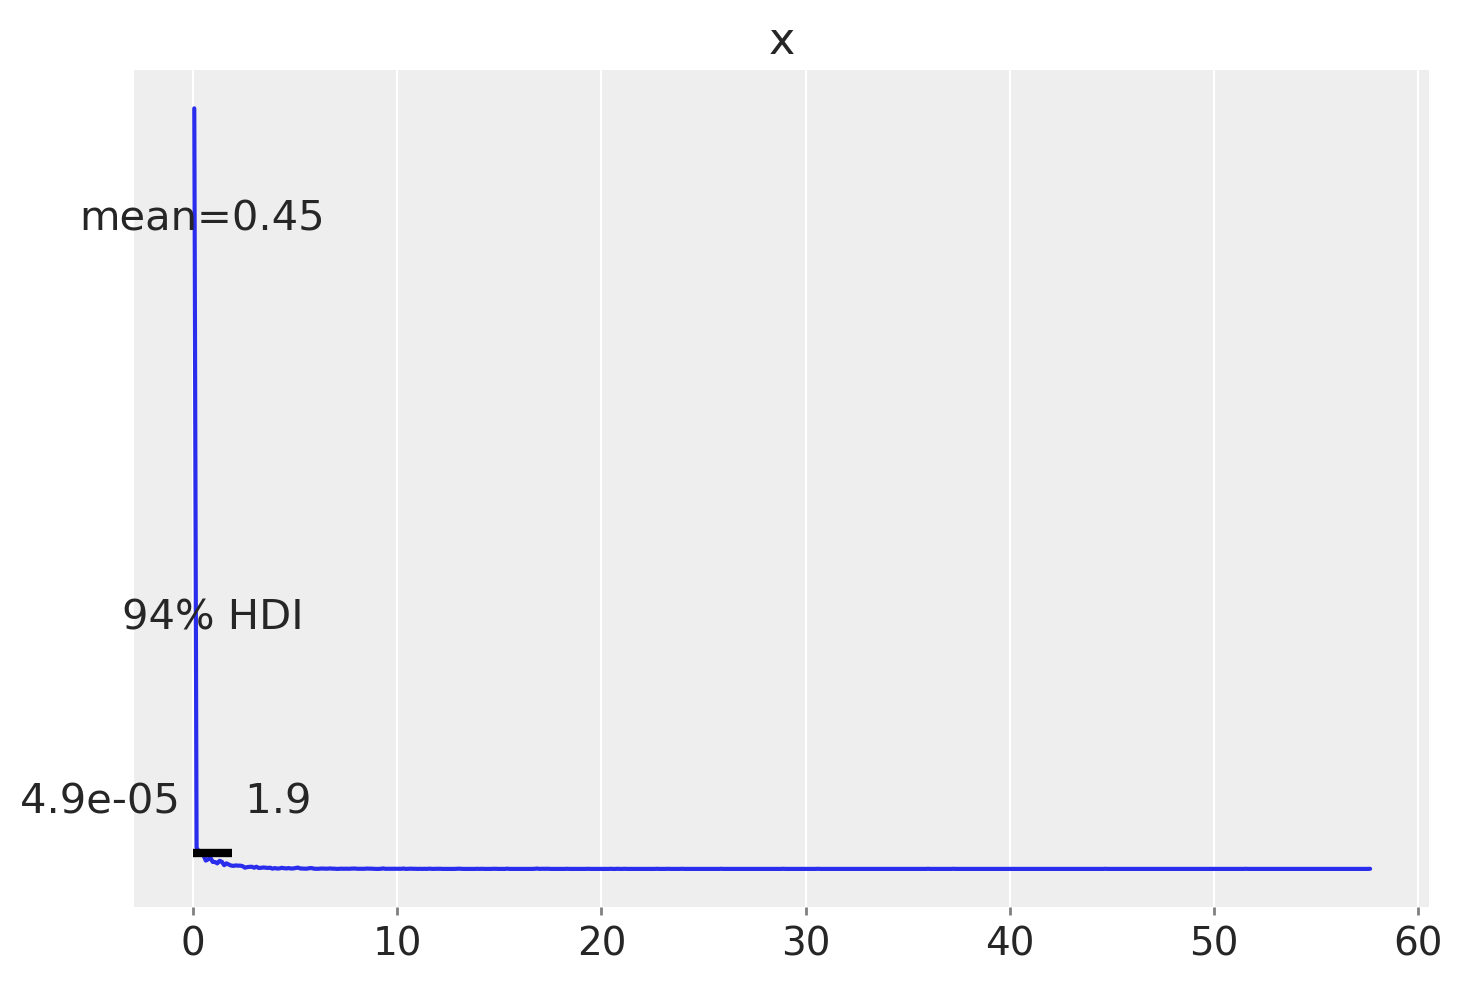

In [11]:
az.plot_posterior(data['PP Package GHG'])

In [22]:
sr = pd.Series(data['PP Package GHG'])
sr.describe()

count    8000.000000
mean        0.450974
std         1.953090
min         0.000049
25%         0.003838
50%         0.009740
75%         0.048269
max        57.705239
dtype: float64

In [25]:
sr.quantile(q=.75)

0.04826884449036192

<AxesSubplot:ylabel='Count'>

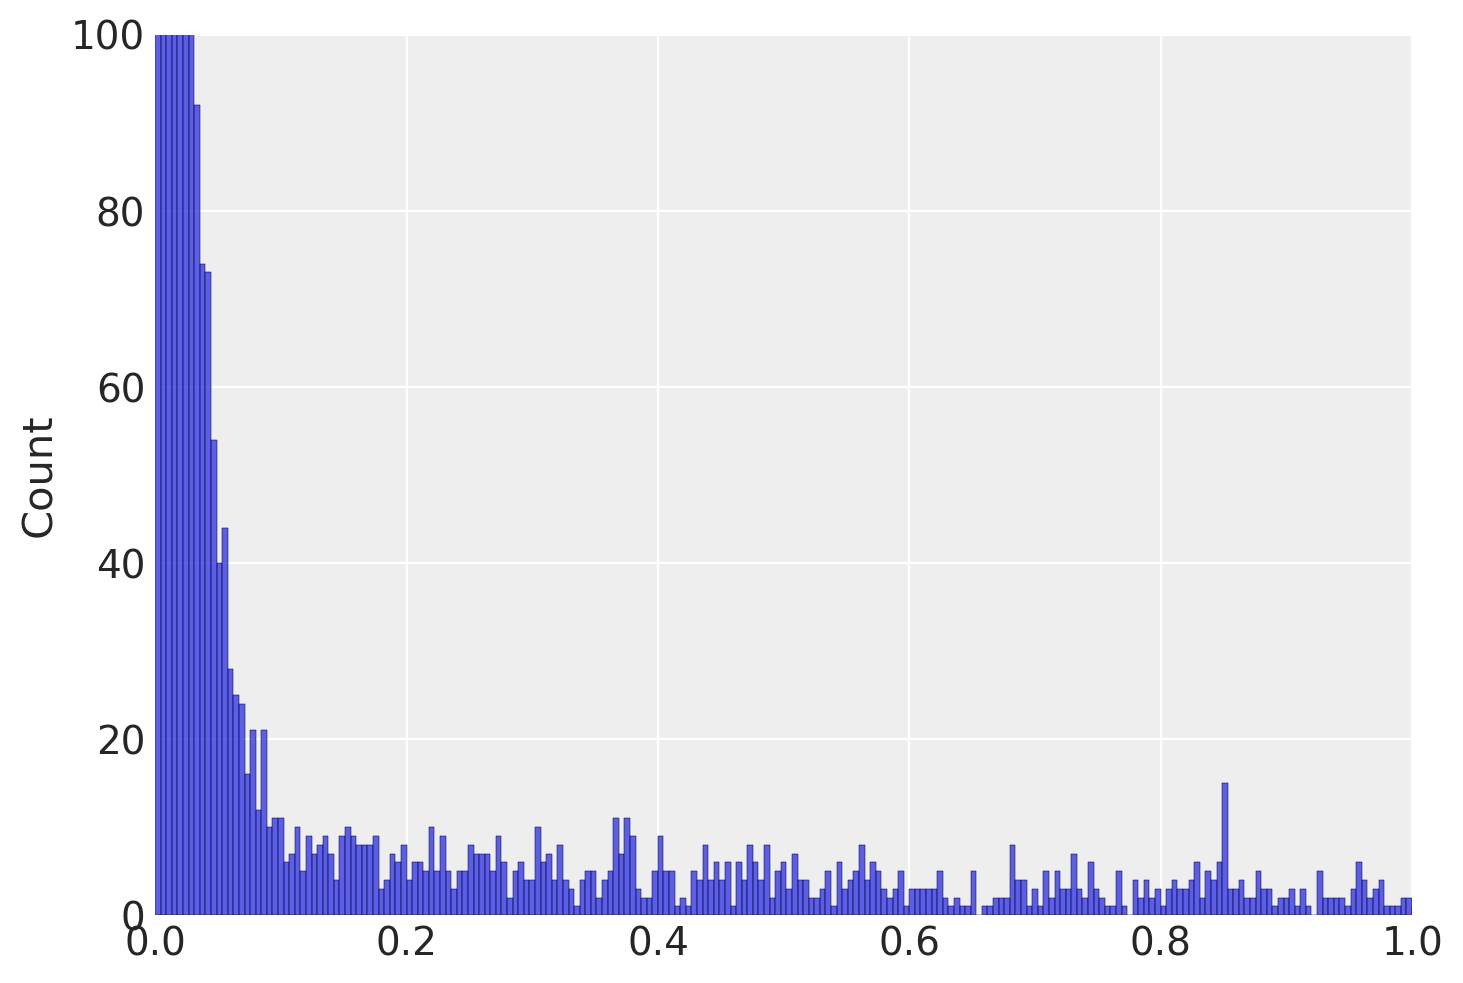

In [14]:
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 100)
sns.histplot(data['PP Package GHG'])

## Bricks & Clicks

### Model

In [49]:
with pm.Model():
    bc_distance = pert(name='BC Delivery Distance', a=2.1, b=4.3, c=7.3, transform=None) # distance travelled per delivery (km)
    bc_van_ghg = pm.Lognormal(name='BC Van GHG', mu=-1.36, sigma=.23) # delivery van GHG per km (kg/km)
    bc_drop_ghg = pm.Deterministic(name='BC GHG per Drop', var=bc_distance * bc_van_ghg)
    
    bc_basket = pert(name='BC Basket Size', a=5, b=45, c=100, transform=None) # basket size distribution for bricks & clicks

    bc_total_item_ghg = pm.Deterministic(name='PP Total GHG per Item', var=bc_drop_ghg / bc_basket)
    
    data = pm.sample(100000, tune=10000)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'BC Delivery Distance': array(4.43333333), 'BC Van GHG_log__': array(-1.36), 'BC Basket Size': array(47.5)}

Initial evaluation results:
BC Delivery Distance   -1.02
BC Van GHG_log__        0.55
BC Basket Size          -inf
Name: Log-probability of test_point, dtype: float64